<a href="https://colab.research.google.com/drive/1fvDBaa6-qc6ggwK37cQe7JZN1fqGhqjG#scrollTo=view-in-github" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Network (DNN)



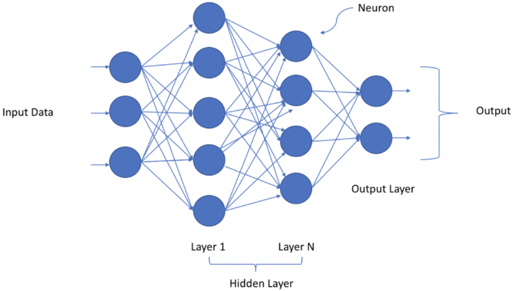

## 1. Load dataset

## 2. Import python libraries and define util functions

In [225]:
''' import '''
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.functional.regression import mean_squared_error, mean_absolute_percentage_error, pearson_corrcoef
from torchsummary import summary

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from utils import get_device, get_data_model_path, set_seed, img_read, img_read_plot, plot_loss, plot_rmse, plot_mape

In [226]:
''' set '''
device = get_device()
data_path, model_path = get_data_model_path(os.getcwd())
set_seed(0)

device, data_path, model_path

(device(type='cuda'),
 'd:\\workspace\\study\\DL2\\dataset',
 'd:\\workspace\\study\\DL2\\model')

## 3. Check dataset

## 4. Convert images into trainable data


In [227]:
''' load data '''
src = os.path.join(data_path, 'data_500')
files = os.listdir(src)


X,Y = [],[]

for file in files:
    X.append(img_read(src, file) / 255.0)   # normalize
    Y.append(float(file[:-4]))              # label -> file name

X = np.array(X)
Y = np.array(Y)

print('X.shape:', X.shape)
print('Y.shape:', Y.shape)

X.shape: (500, 56, 56)
Y.shape: (500,)


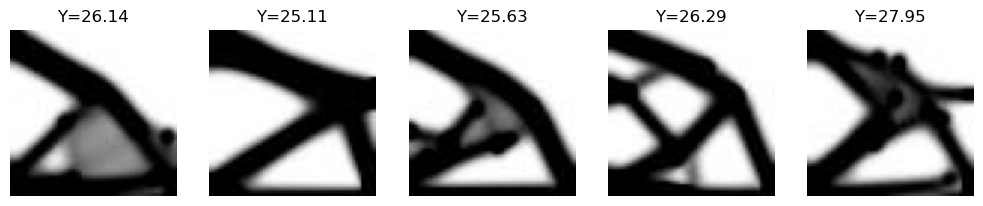

In [228]:
# check images
nplot = 5
idx = np.random.randint(1, 500, nplot)

fig = plt.figure(figsize=(15,5))

for i in range(nplot):
    ax = fig.add_subplot(1, nplot+1, i+1)
    ax.imshow(X[idx[i],:,:], cmap='gray')
    ax.set_title(f"Y={Y[idx[i]]:.2f}")
    ax.axis('off')
plt.show()

In [229]:
''' train test split '''
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X,Y, test_size=0.2, random_state=1, shuffle=True)

print(X_tr.shape, X_ts.shape, Y_tr.shape,Y_ts.shape)


# normalization (Y: 0~1)
scaler = MinMaxScaler()
Y_tr = scaler.fit_transform(Y_tr.reshape(-1,1)) # (400,) -> (400, 1)
Y_ts = scaler.transform(Y_ts.reshape(-1,1))


# convert to Tensor
X_tr = torch.tensor(X_tr, dtype=torch.float32)
Y_tr = torch.tensor(Y_tr, dtype=torch.float32)
X_ts = torch.tensor(X_ts, dtype=torch.float32)
Y_ts = torch.tensor(Y_ts, dtype=torch.float32)

X_tr = X_tr.unsqueeze(1).to(device) # (400, 56, 56) -> (400, 1, 56, 56) : channel 추가
X_ts = X_ts.unsqueeze(1).to(device)
Y_tr = Y_tr.to(device)
Y_ts = Y_ts.to(device)

print(X_tr.size(), X_ts.size())
print(Y_tr.size(), Y_ts.size())

(400, 56, 56) (100, 56, 56) (400,) (100,)
torch.Size([400, 1, 56, 56]) torch.Size([100, 1, 56, 56])
torch.Size([400, 1]) torch.Size([100, 1])


## 5. Set to model architecture

In [230]:
# ''' model '''
# class DNN(nn.Module):
#     def __init__(self,fcs_dim= [56*56,512,256,128,1], output_sigmoid = True):
#         super(DNN, self).__init__()

#         self.flatten = nn.Flatten()
#         # define the fully connected layers
#         self.fcs = nn.ModuleList()
#         for fc_idx in range(len(fcs_dim)-2):
#             self.fcs.append(nn.Linear(fcs_dim[fc_idx], fcs_dim[fc_idx+1]))
#             self.fcs.append(nn.Dropout(0.2))
#             self.fcs.append(nn.ReLU())

#         self.fcs.append(nn.Linear(fcs_dim[len(fcs_dim)-2], fcs_dim[len(fcs_dim)-1]))
#         if output_sigmoid:
#             self.fcs.append(nn.Sigmoid())

#     def forward(self, x):
#         x = self.flatten(x)

#         for fc in self.fcs:
#             x = fc(x)

#         return x


In [231]:
''' model '''
# module
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, p=0.5):
        super(Block, self).__init__()

        self.fc = nn.Linear(in_channels, out_channels)
        self.dropout = nn.Dropout(p=p)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc(x)
        x = self.dropout(x)
        x = self.relu(x)

        return x

# model
class DNN(nn.Module):
    def __init__(self, output_sigmoid=True):
        super(DNN, self).__init__()

        self.flatten = nn.Flatten()

        layers = [
            Block(56*56, 1024, p=0.2),
            Block(1024, 512, p=0.2),
            Block(512, 256, p=0.2),
            Block(256, 256, p=0.2),
            Block(256, 256, p=0.2),
            nn.Linear(256, 1)
        ]
        if output_sigmoid:
            layers.append(nn.Sigmoid())

        self.fcs = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fcs(x)
        
        return x

## 6. (Optional) Set model hyperparameters

In [232]:
# dnn = DNN(fcs_dim= [56*56, 1024, 512, 256, 256, 256, 1], output_sigmoid = True).to(device)
dnn = DNN(output_sigmoid=True).to(device)

summary(dnn, (1, 56, 56))  # input shape: (channels, height, width)
dnn

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3136]               0
            Linear-2                 [-1, 1024]       3,212,288
           Dropout-3                 [-1, 1024]               0
              ReLU-4                 [-1, 1024]               0
             Block-5                 [-1, 1024]               0
            Linear-6                  [-1, 512]         524,800
           Dropout-7                  [-1, 512]               0
              ReLU-8                  [-1, 512]               0
             Block-9                  [-1, 512]               0
           Linear-10                  [-1, 256]         131,328
          Dropout-11                  [-1, 256]               0
             ReLU-12                  [-1, 256]               0
            Block-13                  [-1, 256]               0
           Linear-14                  [

DNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fcs): Sequential(
    (0): Block(
      (fc): Linear(in_features=3136, out_features=1024, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (relu): ReLU()
    )
    (1): Block(
      (fc): Linear(in_features=1024, out_features=512, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (relu): ReLU()
    )
    (2): Block(
      (fc): Linear(in_features=512, out_features=256, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (relu): ReLU()
    )
    (3): Block(
      (fc): Linear(in_features=256, out_features=256, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (relu): ReLU()
    )
    (4): Block(
      (fc): Linear(in_features=256, out_features=256, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (relu): ReLU()
    )
    (5): Linear(in_features=256, out_features=1, bias=True)
    (6): Sigmoid()
  )
)

In [233]:
''' hyper params '''
num_epochs = 300
batch_size = 64
learning_rate = 1e-4

''' loss, optim '''
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=dnn.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.95)

In [234]:
''' dataloader '''
train_dataset = TensorDataset(X_tr, Y_tr)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
''' train '''
loss_tr_hist = []
rmse_tr_hist = []
mape_tr_hist = []

loss_val_hist = []
rmse_val_hist = []
mape_val_hist = []

for epoch in range(num_epochs):

    # training
    dnn.train()
    total_loss = 0.0
    rmse_tr = 0.0
    mape_tr = 0.0

    for x, y in train_loader:
        optimizer.zero_grad()
        output = dnn(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # inverse transformation (for calc metrics)
        output = output.cpu().detach().numpy().reshape(1,-1)
        output = scaler.inverse_transform(output)
        output = torch.from_numpy(output).clone().detach()#.reshape(1,-1)
        
        y = y.cpu().detach().numpy().reshape(1,-1)
        y = scaler.inverse_transform(y)
        y = torch.from_numpy(y).clone().detach()#.reshape(1,-1)

        rmse_tr += mean_squared_error(output, y, squared=False).item() # False=RMSE, True=MSE
        mape_tr += mean_absolute_percentage_error(output, y).item() * 100

        # if mean_absolute_percentage_error(output, y).item() > 1000:
        #     break

    # if mape_train > 1000:
    #     break
    avg_loss_tr = total_loss / len(train_loader)
    avg_rmse_tr = rmse_tr / len(train_loader)
    avg_mape_tr = mape_tr / len(train_loader)

    # history
    loss_tr_hist.append(avg_loss_tr)
    rmse_tr_hist.append(avg_rmse_tr)
    mape_tr_hist.append(avg_mape_tr)


    # validation
    dnn.eval()
    with torch.no_grad():
        output_val = dnn(X_ts)
        loss_val = criterion(output_val, Y_ts).item()

        # inverse transformation
        output_val = output_val.cpu().detach().numpy().reshape(1,-1)
        output_val = scaler.inverse_transform(output_val)
        output_val = torch.from_numpy(output_val).clone().detach().reshape(1,-1)

        y_val  = Y_ts.cpu().detach().numpy().reshape(1,-1)
        y_val  = scaler.inverse_transform(y_val)
        y_val  = torch.from_numpy(y_val).clone().detach().reshape(1,-1)

        rmse_val = mean_squared_error(output_val, y_val, squared=False).item()
        mape_val = mean_absolute_percentage_error(output_val, y_val).item() * 100

    # history
    loss_val_hist.append(loss_val)
    rmse_val_hist.append(rmse_val)
    mape_val_hist.append(mape_val)
    print(f"Epoch [{epoch+1:3}/{num_epochs}], Train RMSE: {avg_rmse_tr:.4f}, Train MAPE: {avg_mape_tr:.4f}, Val RMSE: {rmse_val:.4f}, Val MAPE: {mape_val:.4f}")

scheduler.step()

Epoch [  1/300], Train RMSE: 1.4830, Train MAPE: 4.7443, Val RMSE: 1.5017, Val MAPE: 4.7641
Epoch [  2/300], Train RMSE: 1.4617, Train MAPE: 4.6254, Val RMSE: 1.4810, Val MAPE: 4.6912
Epoch [  3/300], Train RMSE: 1.4759, Train MAPE: 4.6725, Val RMSE: 1.4657, Val MAPE: 4.6465
Epoch [  4/300], Train RMSE: 1.4377, Train MAPE: 4.5297, Val RMSE: 1.4307, Val MAPE: 4.5399
Epoch [  5/300], Train RMSE: 1.3936, Train MAPE: 4.3686, Val RMSE: 1.3706, Val MAPE: 4.3566
Epoch [  6/300], Train RMSE: 1.3352, Train MAPE: 4.2478, Val RMSE: 1.2708, Val MAPE: 4.0264
Epoch [  7/300], Train RMSE: 1.2678, Train MAPE: 4.0219, Val RMSE: 1.3106, Val MAPE: 4.1102
Epoch [  8/300], Train RMSE: 1.1857, Train MAPE: 3.7295, Val RMSE: 1.0785, Val MAPE: 3.3287
Epoch [  9/300], Train RMSE: 1.1359, Train MAPE: 3.4776, Val RMSE: 1.0029, Val MAPE: 3.0122
Epoch [ 10/300], Train RMSE: 0.9921, Train MAPE: 3.0675, Val RMSE: 1.0057, Val MAPE: 3.0364
Epoch [ 11/300], Train RMSE: 1.0008, Train MAPE: 3.0405, Val RMSE: 0.9381, Val M

## 7. Visualize learning history

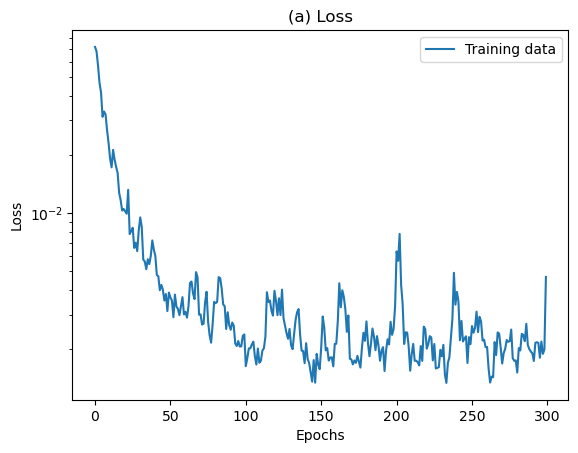

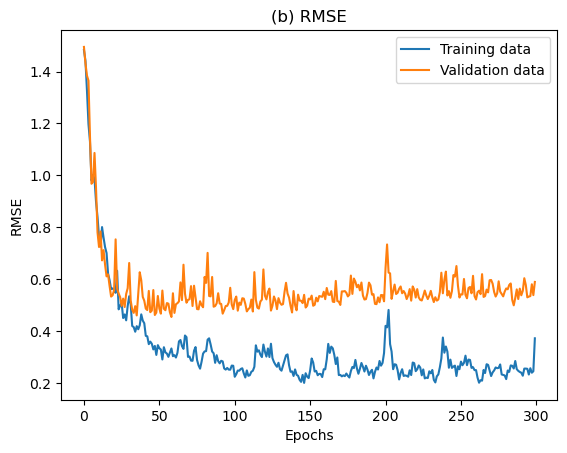

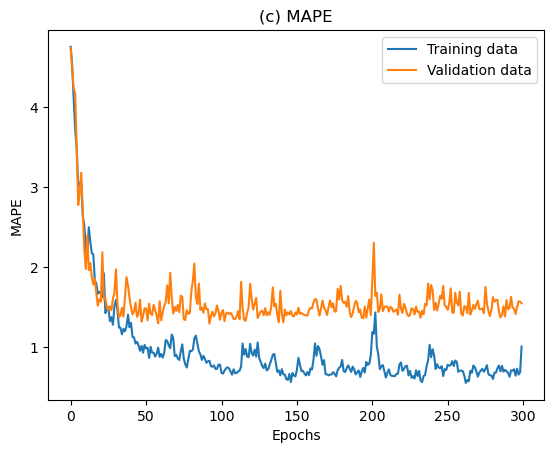

In [ ]:
# graph visualization
plot_loss(loss_tr_hist, loss_val_hist, '(a) Loss')
plot_rmse(rmse_tr_hist, rmse_val_hist, '(b) RMSE')
plot_mape(mape_tr_hist, mape_val_hist, '(c) MAPE')

## 8. Evaluate model performance

In [ ]:
# load the saved model and set it to evaluation mode
dnn.eval().to(device)

# predict using the model (on the validation dataset)
pred_labels = dnn(X_ts)  # returns the predicted values (y_pred)

# evaluate the model performance (RMSE & MAPE)
each_rmse_test = mean_squared_error(pred_labels, Y_ts, squared=False).item()
each_mape_test = mean_absolute_percentage_error(Y_ts, pred_labels).item()
r2 = pearson_corrcoef(pred_labels, Y_ts).item()


NameError: name 'r_val' is not defined

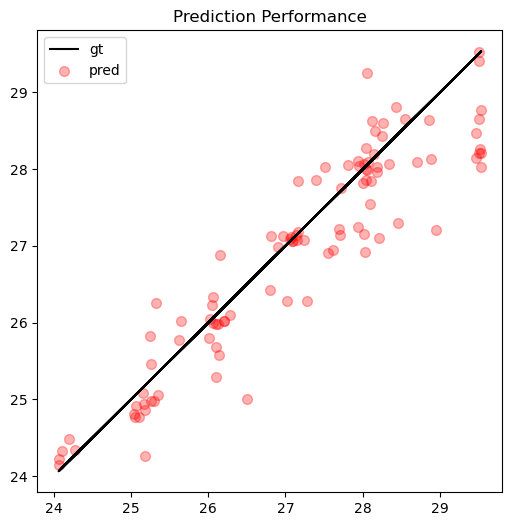

In [ ]:

# calculate and visualize the R2
pred_labels = pred_labels.cpu().detach().numpy()
Y_ts = Y_ts.cpu().numpy()
pred_labels = scaler.inverse_transform(pred_labels)
Y_ts = scaler.inverse_transform(Y_ts)


plt.figure(figsize=(6,6))
plt.plot(Y_ts, Y_ts,'-',color='black')
plt.scatter(Y_ts, pred_labels,s=50,alpha=0.3,color='red')
plt.legend(['gt','pred'],loc='upper left')
plt.title('Prediction Performance')
plt.text(Y_ts.max(),Y_ts.min(),'R2 = {}'.format(round(r_val(Y_ts, pred_labels),4)))
plt.xlabel('Ground Truth')
plt.ylabel('Prediction Value')
plt.grid(True)



# fine-tune your model by minimizing rmse value (validation dataset)
print(" ----- evaluation results ----- ")
print(" ")
print("valid RMSE : " , np.round(each_rmse_test,4))
print("valid MAPE : " , np.round(each_mape_test,4))
print("valid R2 : " , r_val(Y_ts, pred_labels))